# Creating networks

Scripts are very handy when preparing data for network analysis. Tedious tasks can be automated, like cleaning a data set, converting one table layout to another, or similar things. Often, these tasks are not specific to network analysis, e.g. when handling spreadsheets that are eventually to be imported into a network analysis software.

But it is also possible to deal with networks as networks in Python. This allows us to define rules about how to create a network from our data. In the case of a text, we could assume that two persons mentioned in the same section of the text can be regarded as having a connection. What counts as “section” here can vary—it might be a page, a paragraph, or just a sentence. Similar rules could be defined for other types of data, e.g. online forums.

We will look at the example of the legend of the holy grail. In this case, there is an XML encoded version of a french edition [available](http://portal.textometrie.org/txm/texte/quete). We will use the XML version, as it already contains information about sentences, words, and also names.

## Creating edges

Before we look at the concrete example, let us look at the general mechanism. The rule for identifying edges in our network is:

1. Find all sentences.
2. In each sentence, find all names.
3. For each possible combination of these names, create an edge in the network.

This third step requires to find all possible pairs in a list of names. There is a function for that:

In [1]:
from itertools import combinations

names = ['Galaad', 'Lancelot', 'Perceval']
relations = combinations(names, 2)
for first, second in relations:
    print(first + ' + ' + second)

Galaad + Lancelot
Galaad + Perceval
Lancelot + Perceval


## Extracting XML

Most of you probably already worked with HTML. If you are not familiar with the TEI dialect of XML: It is for preserving humanities data what HTML is for web documents. You might want to check out the [Guidelines](http://www.tei-c.org/release/doc/tei-p5-doc/en/html/index.html).

We are interested only in three types of information in the XML document:

1. Sentences that contain
2. words which have
3. a word class, e.g. “Name” (or in Frensh linguists terms: Nom propre).

We can use [XPath](www.w3schools.com/xpath/) in order to extract these parts of the document.

First, we open the XML file. *Note: As XML namespace make everything more complicated, I removed the namespace declaration from the document. If you work regularly with XML, you might want to learn about namespaces.*

In [2]:
from lxml import etree

doc = etree.parse('qgraal_cm_2013-07-cour.xml')
doc.getroot()

<Element TEI at 0x7f2f840ddac8>

We use `etree.parse()` instead of `open()` since we want not to access the raw text, but a parsed version of the XML document. This allows us to easily access the structural aspects of the XML tree.

Since we want to build a network (or graph) from the document, we also create an empty graph. At this point, it will contain no nodes or edges, and we will add those gradually.

In [3]:
import networkx

graph = networkx.Graph()
print(networkx.info(graph))

Name: 
Type: Graph
Number of nodes: 0
Number of edges: 0



Now we want to look at every sentence in the text and find words that are names.

1. Sentences are encoded with the XML tag `<s>`.
2. Words are encoded with the XML tag `<w>`.
3. Names have the attribute `type` of the `<w>` tag set to `"NOMpro"`.

In [4]:
for sentence in doc.iter('s'):
    words = sentence.iter('w')
    name_words = [word for word in words if word.get('type') == 'NOMpro']
    names = [etree.tostring(word, method='text', encoding='unicode') for word in name_words]
    names = [name.strip() for name in names]
    for source, target in combinations(names, 2):
        graph.add_edge(source, target)

print(networkx.info(graph))

Name: 
Type: Graph
Number of nodes: 158
Number of edges: 490
Average degree:   6.2025


In order to see if this worked, we can now plot the network.

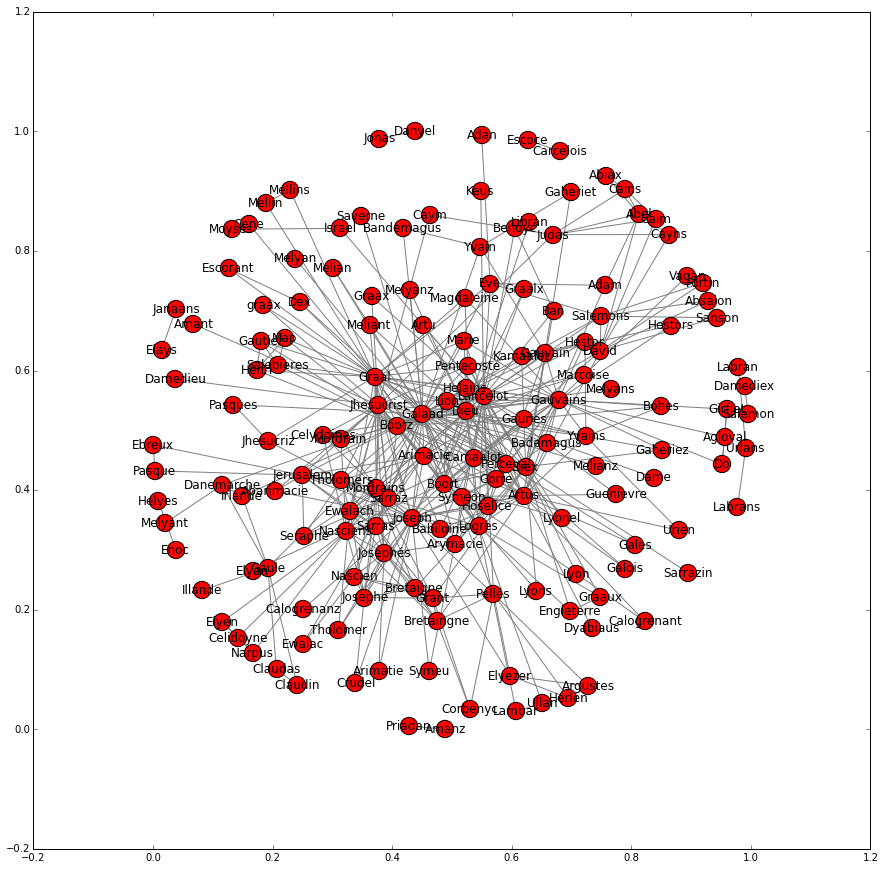

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 15

networkx.draw_networkx(graph, edge_color='gray')

With this number of nodes, it is not easy to really see details. However, it is still possible to get some metrics. Using the `Counter()` function, we can list the nodes with the highest degree.

In [6]:
from collections import Counter
nodes_by_degree = Counter(graph.degree())
nodes_by_degree.most_common(10)

[('Galaad', 54),
 ('Lancelot', 40),
 ('Graal', 35),
 ('Joseph', 32),
 ('Dieu', 32),
 ('Jhesucrist', 30),
 ('Gauvains', 29),
 ('Artus', 25),
 ('Diex', 25),
 ('Boort', 20)]

A first analysis often highlights problems in the data. For example, we can see that “Dieu” and “Diex” are two nodes, although they should probably be only one node. And we see that some words are encoded as names that are not persons, e.g. “Graal”, but—depending on your philosophical standpoint—possibly also “Dieu.” So it might be necessary to add additional cleanup steps.

While network creation in Python is really comfortable, the exploration and visualisation of networks is a bit cumbersome. So it makes sense to move those steps to better suited programs, like Gephi. Python then becomes interesting again if we want to perform certain analyses repeatedly, e.g. draw the ego network of each of our 150 nodes.

A suitable exchange format for networks is GraphML.

In [7]:
networkx.write_graphml(graph, 'Graal.graphml')